<a href="https://colab.research.google.com/github/colgate116/T_rex_game/blob/master/fish_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from numpy.ma.core import argmax
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.transform import resize

from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

replace __MACOSX/train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
{'BET': 0, 'NoF': 1, 'LAG': 2, 'DOL': 3, 'ALB': 4, 'YFT': 5, 'SHARK': 6, 'OTHER': 7}


100%|██████████| 299/299 [00:42<00:00,  7.08it/s]


(3777, 150, 150, 3) (3777, 8)


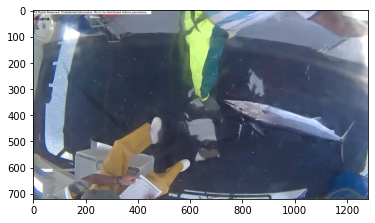

In [ ]:
"""!unzip -q /content/drive/MyDrive/train.zip
!rm -rf train/.DS_Store

folder = 'train/OTHER'
files = os.listdir(folder)
img = plt.imread(folder + '/' + files[0])
plt.figure()
plt.imshow(img)

classes = {cls: i for i, cls in enumerate(os.listdir('train')[:8])}
print(classes)

x_train, y_train = [], []
for cls in classes:
  for file in tqdm(os.listdir(os.path.join('train', cls))):
    img = plt.imread(os.path.join('train', cls, file))
    img = resize(img, (150, 150))
    x_train.append(img)
    y_train.append(classes[cls])

x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = to_categorical(y_train)
print(x_train.shape, y_train.shape)

np.savez('/content/drive/MyDrive/data', x=x_train, y=y_train)"""

Getting data

In [ ]:
#{'BET': 0, 'NoF': 1, 'LAG': 2, 'DOL': 3, 'ALB': 4, 'YFT': 5, 'SHARK': 6, 'OTHER': 7}

In [ ]:
file = np.load('/content/drive/MyDrive/data.npz')

In [ ]:
x_train, x_test, y_train,  y_test = train_test_split(file['x'], file['y'], test_size=0.15)

In [ ]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3210, 150, 150, 3) (567, 150, 150, 3)
(3210, 8) (567, 8)


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0.05,
                           patience=8,
                           verbose=1,
                           mode='min'
                          )

In [ ]:
#class_weight={0: 0.05, 1: 0.12, 2: 0.02, 3: 0.03, 4: 0.46, 5: 0.19, 6: 0.05, 7: 0.08}

Тестовые данные

In [ ]:
"""!unzip -q /content/drive/MyDrive/test_stg1.zip

folder = 'test_stg1/'
files = os.listdir(folder)

test1 = []
for i in range(len(files)):
 test1.append(plt.imread(folder + '/' + files[i]))
 test1[i] = resize(test1[i], (150, 150))
test1 = np.array(test1)
np.savez('/content/drive/MyDrive/pred1.npz', test1=test1)"""

In [ ]:
test1=np.load('/content/drive/MyDrive/pred1.npz')
test1=np.array(test1['test1'])

In [ ]:
"""!7z x /content/drive/MyDrive/test_stg2.7z

folder = 'test_stg2/'
files = os.listdir(folder)

test2 = []
for i in range(len(files)):
  test2.append(plt.imread(folder + '/' + files[i]))
  test2[i]=test2[i].astype('float16')
  test2[i] = resize(test2[i], (150, 150))
test2 = np.array(test2)
np.savez('/content/drive/MyDrive/pred2.npz', test2=test2)"""

In [ ]:
test2=np.load('/content/drive/MyDrive/pred2.npz')
test2=np.array(test2['test2'])

сверточая НС

In [ ]:
"""model = models.Sequential(name='convolution_model')
model.add(layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.Conv2D(64, 3, activation='relu',padding='same'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(64, 3, activation='relu',padding='same',))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(Dropout(0.7))
model.add(layers.Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.7))
model.add(layers.Dense(8, activation='softmax',kernel_regularizer='l2'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()"""

In [ ]:
"""model.fit(
    x_train, y_train,
    shuffle=True,
    validation_data=(x_test, y_test),
    epochs=30,
    callbacks=early_stop
)"""

In [ ]:
"""a=20
plt.imshow(x_test[a])
print('answer',argmax(y_test[a]))
print('pred',argmax(model.predict(x_test[a].reshape(-1,150,150,3))))"""

Transfer learning

In [ ]:
vgg = VGG16(include_top=False, input_shape=(150, 150, 3), weights='imagenet')
vgg.trainable = False

vgg.layers[17].trainable = True

x = layers.Flatten()(vgg.output)
x = layers.Dropout(0.7)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(8, activation='softmax', kernel_regularizer='l2')(x)

model = models.Model(vgg.input, x, name='transfer_learning')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(
    x_train, y_train,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=early_stop,
    epochs=10)

In [ ]:
model.save('transfer_learning.h5')

In [ ]:
model = load_model('transfer_learning.h5')

Predicts

In [ ]:
#{'BET': 0, 'NoF': 1, 'LAG': 2, 'DOL': 3, 'ALB': 4, 'YFT': 5, 'SHARK': 6, 'OTHER': 7}

In [ ]:
pred1=model.predict(test1.reshape(-1,150,150,3))

32/32 [==============================] - 272s 8s/step


In [ ]:
pred2=model.predict(test2.reshape(-1,150,150,3))

 22/380 [>.............................] - ETA: 51:39

KeyboardInterrupt: ignored

In [ ]:
pred1

In [ ]:
pred2